In [1]:
from warnings import filterwarnings 
filterwarnings("ignore") 

In [3]:
#import keras
#from keras.layers import Dense,Activation, Dropout,Flatten,Conv2D,MaxPooling2D, BatchNormalization, MaxPooling2D
#from keras.models import Sequential
import numpy as np
import matplotlib.pyplot as plt 
import cv2

#import ssl
#ssl._create_default_https_context = ssl._create_unverified_context

In [5]:
def detect_and_describe(image):
    # Convert the image to grayscale as SIFT operates on single-channel image
    gray = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
    
    # Create instance of the SIFT detector
    sift = cv2.SIFT_create()
    
    # Find the keypoints and compute their descriptors in one step
    keypoints, descriptors = sift.detectAndCompute(gray, None)
    
    return keypoints, descriptors

In [7]:
def match_keypoints(desc1, desc2):
    # Create a BFMatcher object with distance measurement cv2.NORM_L2
    bf = cv2.BFMatcher(cv2.NORM_L2, crossCheck=True)
    
    # Match descriptors
    matches = bf.match(desc1, desc2)
    print(matches [:5])
    
    # Sort the matches based on distance. Best match first
    matches = sorted(matches, key = lambda x:x.distance)
    print(matches [:5])
    
    return matches

A ***homography*** is a transformation that maps points from one plane to another. It can represent a wide range of transformations, including translation, rotation, scaling, and perspective transformations. Mathematically, a homography is represented by a 3x3 matrix.  Homography is particularly useful in image stitching, perspective correction, and other geometric transformations.

***Homography*** we will caluclate here is a transofrmation matrix computed between two sets of matched keypoints from two images. This matrix describes the transformation needed to map points from one image to the corresponding points in the other image.

In [14]:
def get_homography(kp1, kp2, matches, reproj_thresh=4.0):
    # Extract the matched keypoints
    ptsA = np.float32([kp1[m.queryIdx].pt for match in matches])
    ptsB = np.float32([kp2[m.trainIdx].pt for match in matches])
    
    # Compute the homography matrix
    (H, status) = cv2.findHomography(ptsA, ptsB, cv2.RANSAC, reproj_thresh)
    
    # H is the resulting 3x3 homography matrix.
    # status is a mask indicating which points are inliers (1) and which are outliers (0).
    return H, status

Real-world data often contain outliers—points that do not fit the model due to noise, occlusion, or mismatches. ***RANSAC*** helps to robustly estimate the homography matrix by iteratively selecting random subsets of the matched points and computing the homography matrix. It then evaluates how well the computed homography matches the rest of the points. Points that fit well with the computed homography are considered inliers, and those that do not are considered outliers.

In [11]:
def stitch_images(image1, image2, H):
    # Get dimensions of the input images
    (h1, w1) = image1.shape[:2]
    (h2, w2) = image2.shape[:2]
    
    # Warp the second image to the plane of the first image
    result = cv2.warpPerspective(image2, H, (w1 + w2, h1))
    
    # Place the first image in the result
    result[0:h1, 0:w1] = image1
    
    return result

def autostitch(image1_path, image2_path):
    # Read input images
    image1 = cv2.imread(image1_path)
    image2 = cv2.imread(image2_path)
    
    # Detect keypoints and descriptors
    kp1, desc1 = detect_and_describe(image1)
    kp2, desc2 = detect_and_describe(image2)
    
    # Match keypoints
    matches = match_keypoints(desc1, desc2)
    
    # Compute the homography matrix
    H, status = get_homography(kp1, kp2, matches)
    
    # Stitch the images together
    result = stitch_images(image1, image2, H)
    
    return result

### Data Extraction

In [ ]:
# Paths to input images
image1_path = 'path_to_first_image.jpg'
image2_path = 'path_to_second_image.jpg'

# Perform autostitching
result_image = autostitch(image1_path, image2_path

In [ ]:
# Display the result
cv2.imshow('Stitched Image', result_image)
cv2.waitKey(0)
cv2.destroyAllWindows()

### Data Extraction

In [10]:
train_path = 'Dataset/seg_train'
val_path = 'Dataset/seg_val'
test_path = 'Dataset/seg_test'

class_names = ['buildings' , 'forest' , ' glacier' , 'mountain' , 'sea' , 'street']
class_names_codes = {'buildings':0 , 'forest':1 , ' glacier':2 , 'mountain':3 , 'sea':4 , 'street':5}
x_train = []
y_train = []
x_test = []
y_test = []

for class_name in class_names :
    train_files = glob.glob(train_path + '/' + class_name + '/*.jpg')
    for file in train_files : 
        img = cv2.imread(file)
        img = cv2.resize(img , (150 , 150))
        x_train.append(img)
        y_train.append(class_names_codes[class_name])
    test_files = glob.glob(test_path + '/' + class_name + '/*.jpg' )
    for file in test_files : 
        img = cv2.imread(file)
        img = cv2.resize(img , (150 , 150))
        x_test.append(img)
        y_test.append(class_names_codes[class_name])


### Testing the Manual Augmenter

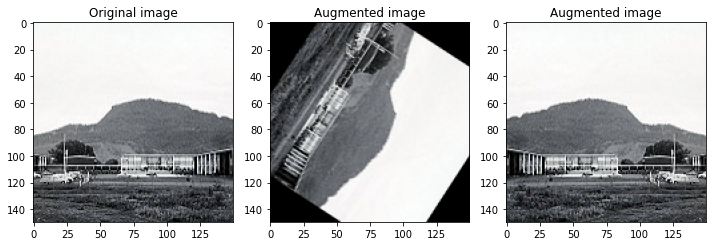

In [11]:
test_img = x_train[0] #test for the first image
all_images = augment_data(callable_list, test_img)
augmented_images= all_images[1:] #extracting only the augmented images

import matplotlib.pyplot as plt

plt.figure(figsize=(10, 10))

#plotting the original image
plt.subplot(1, 3, 1)
plt.imshow(all_images[0])
plt.title('Original image')

for i in range( len(augmented_images)):
    plt.subplot(1, 3, i + 2)
    plt.imshow(augmented_images[i])
    plt.title('Augmented image')

plt.tight_layout()
plt.show()


### Augmenting training images

In [12]:
x_train_augmented = []
y_train_augmented = []
num_augmentations = len(callable_list)

for i in range (len(x_train)):
    augmented_images = augment_data(callable_list, x_train[i])
    x_train_augmented.extend(augmented_images)
    y_train_augmented.extend([y_train[i]] * (num_augmentations + 1))


Checking on images and label sizes to ensure the operations done above are correct

In [13]:
print(len(x_train_augmented))
print(len(y_train_augmented))

34890
34890


# 2 - Using ImageDataGeneration for Automatic Image Augmentation

### 2 - 1 Theoritcal

The `ImageDataGenerator` class from `tensorflow.keras.preprocessing.image` is a powerful tool for generating batches of tensor image data with real-time data augmentation. This functionality is particularly useful when working with image data in deep learning projects, as it allows for on-the-fly augmentation of images, which helps improve the robustness and performance of models -> ***its optimized because it loads data batch by batch so memory wont run out***

### Key Features

1. **Data Augmentation:**
   - It can perform a variety of transformations on the images such as rotation, shifting, shearing, zooming, flipping, and more. These transformations help in creating more diverse training data from existing images, reducing overfitting, and improving the model's generalization ability.

2. **Normalization:**
   - It allows for feature-wise centering, normalization, and rescaling of the images.

3. **Batch Generation:**
   - It generates batches of augmented/normalized data. This is useful for feeding data into models for training or prediction in an efficient manner.

### Example Usage

Here is an example of how to use `ImageDataGenerator`:

```python
from tensorflow.keras.preprocessing.image import ImageDataGenerator

# Create an instance of ImageDataGenerator with desired augmentations
datagen = ImageDataGenerator(
    rotation_range=40,
    width_shift_range=0.2,
    height_shift_range=0.2,
    shear_range=0.2,
    zoom_range=0.2,
    horizontal_flip=True,
    fill_mode='nearest'
)

# Load an example image (assuming you have it as a Numpy array)
# You can use the image loading utility provided by Keras or any other method
from tensorflow.keras.preprocessing import image
import numpy as np

# Example image path
img_path = 'path/to/your/image.jpg'
img = image.load_img(img_path)  # Load image
x = image.img_to_array(img)     # Convert image to Numpy array
x = np.expand_dims(x, axis=0)   # Add batch dimension

# Generate batches of augmented images from the original image
i = 0
for batch in datagen.flow(x, batch_size=1):
    # Save or visualize the generated images
    # For example, save the first 5 generated images
    img_gen = image.array_to_img(batch[0])
    img_gen.save(f'augmented_image_{i}.jpg')
    
    i += 1
    if i >= 5:
        break


### 2 - 2 Practical 

In [14]:
# Convert lists to numpy arrays 
#without normalization as the preprocessing function I will use later ".mobilenet.preprocess_input" normlaizes the input

x_train = np.array(x_train, dtype=np.float32)
y_train = np.array(y_train, dtype=np.int32)
x_test = np.array(x_test, dtype=np.float32) 
y_test = np.array(y_test, dtype=np.int32)

In [17]:
import tensorflow as tf

In [18]:
# One-hot encode the labels 
y_train = tf.keras.utils.to_categorical(y_train,num_classes=len(class_names))
y_test = tf.keras.utils.to_categorical(y_test, num_classes=len(class_names))

In [25]:
from keras.preprocessing.image import ImageDataGenerator

In [26]:
# Create ImageDataGenerators with preprocessing function for MobileNet

#augment training images
train_datagen = ImageDataGenerator(preprocessing_function=tf.keras.applications.mobilenet.preprocess_input , rotation_range=40,
    width_shift_range=0.2,
    height_shift_range=0.2,
    shear_range=0.2,
    zoom_range=0.2,
    horizontal_flip=True,
    fill_mode='nearest')

#won't augment testing images as we want to evaluate the model 
#on the original data without any modifications to get a true sense of its performance.
test_datagen = ImageDataGenerator(preprocessing_function=tf.keras.applications.mobilenet.preprocess_input)

In [31]:
# Create generators

train_iterator = datagen.flow_from_directory(
    train_path,
    target_size=(224, 224),
    batch_size=190,
    class_mode='categorical',
    classes=class_names)

test_iterator = test_datagen.flow_from_directory(
    test_path,
    target_size=(224, 224),
    batch_size=10,
    class_mode='categorical',
    classes=class_names)

Found 11630 images belonging to 6 classes.
Found 2447 images belonging to 6 classes.


In [32]:
# Augment and save a few images from the training data
augmented_image_dir = 'augmented_images/'
os.makedirs(augmented_image_dir, exist_ok=True)

# Generate and save augmented images from the training data
i = 0
for batch in train_datagen.flow(x_train, batch_size=1, save_to_dir=augmented_image_dir, save_prefix='aug', save_format='jpeg'):
    i += 1
    if i >= len(x_train):  # Save images for all data points
        break

In [35]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout
from tensorflow.keras.optimizers import Adam

In [36]:
# Define a simple CNN model
model = Sequential([
    Conv2D(32, (3, 3), activation='relu', input_shape=(224, 224, 3)),
    MaxPooling2D((2, 2)),
    Conv2D(64, (3, 3), activation='relu'),
    MaxPooling2D((2, 2)),
    Conv2D(128, (3, 3), activation='relu'),
    MaxPooling2D((2, 2)),
    Flatten(),
    Dense(512, activation='relu'),
    Dropout(0.5),
    Dense(len(class_names), activation='softmax')
])


In [37]:
# Compile the model
model.compile(
    optimizer=Adam(learning_rate=0.001),
    loss='categorical_crossentropy',
    metrics=['accuracy']
)

In [38]:
# Train the model
model.fit(
    train_iterator,
    steps_per_epoch=train_iterator.samples // train_iterator.batch_size,
    epochs=10
)

Epoch 1/10
61/61 [==============================] - 820s 13s/step - loss: 34.3116 - accuracy: 0.2095
Epoch 2/10
18/61 [=======>......................] - ETA: 8:30 - loss: 1.7088 - accuracy: 0.1960

KeyboardInterrupt: 

In [ ]:
# Evaluate the model
loss, accuracy = model.evaluate(
    test_iterator,
    steps=test_iterator.samples // test_iterator.batch_size
)
print(f'Test loss: {loss}')
print(f'Test accuracy: {accuracy}')

# Evaluate model

In [39]:
import tensorflow as tf

print("Num GPUs Available: ", len(tf.config.experimental.list_physical_devices('GPU')))


Num GPUs Available:  0


In [40]:
nvidia-smi

NameError: name 'nvidia' is not defined